In [1]:
import matplotlib.pyplot as plt
plt.rc('font', family='AppleGothic')
plt.rc('axes', unicode_minus=False)

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')
# 레티나 디스플레이 설정

In [2]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

In [3]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [6]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


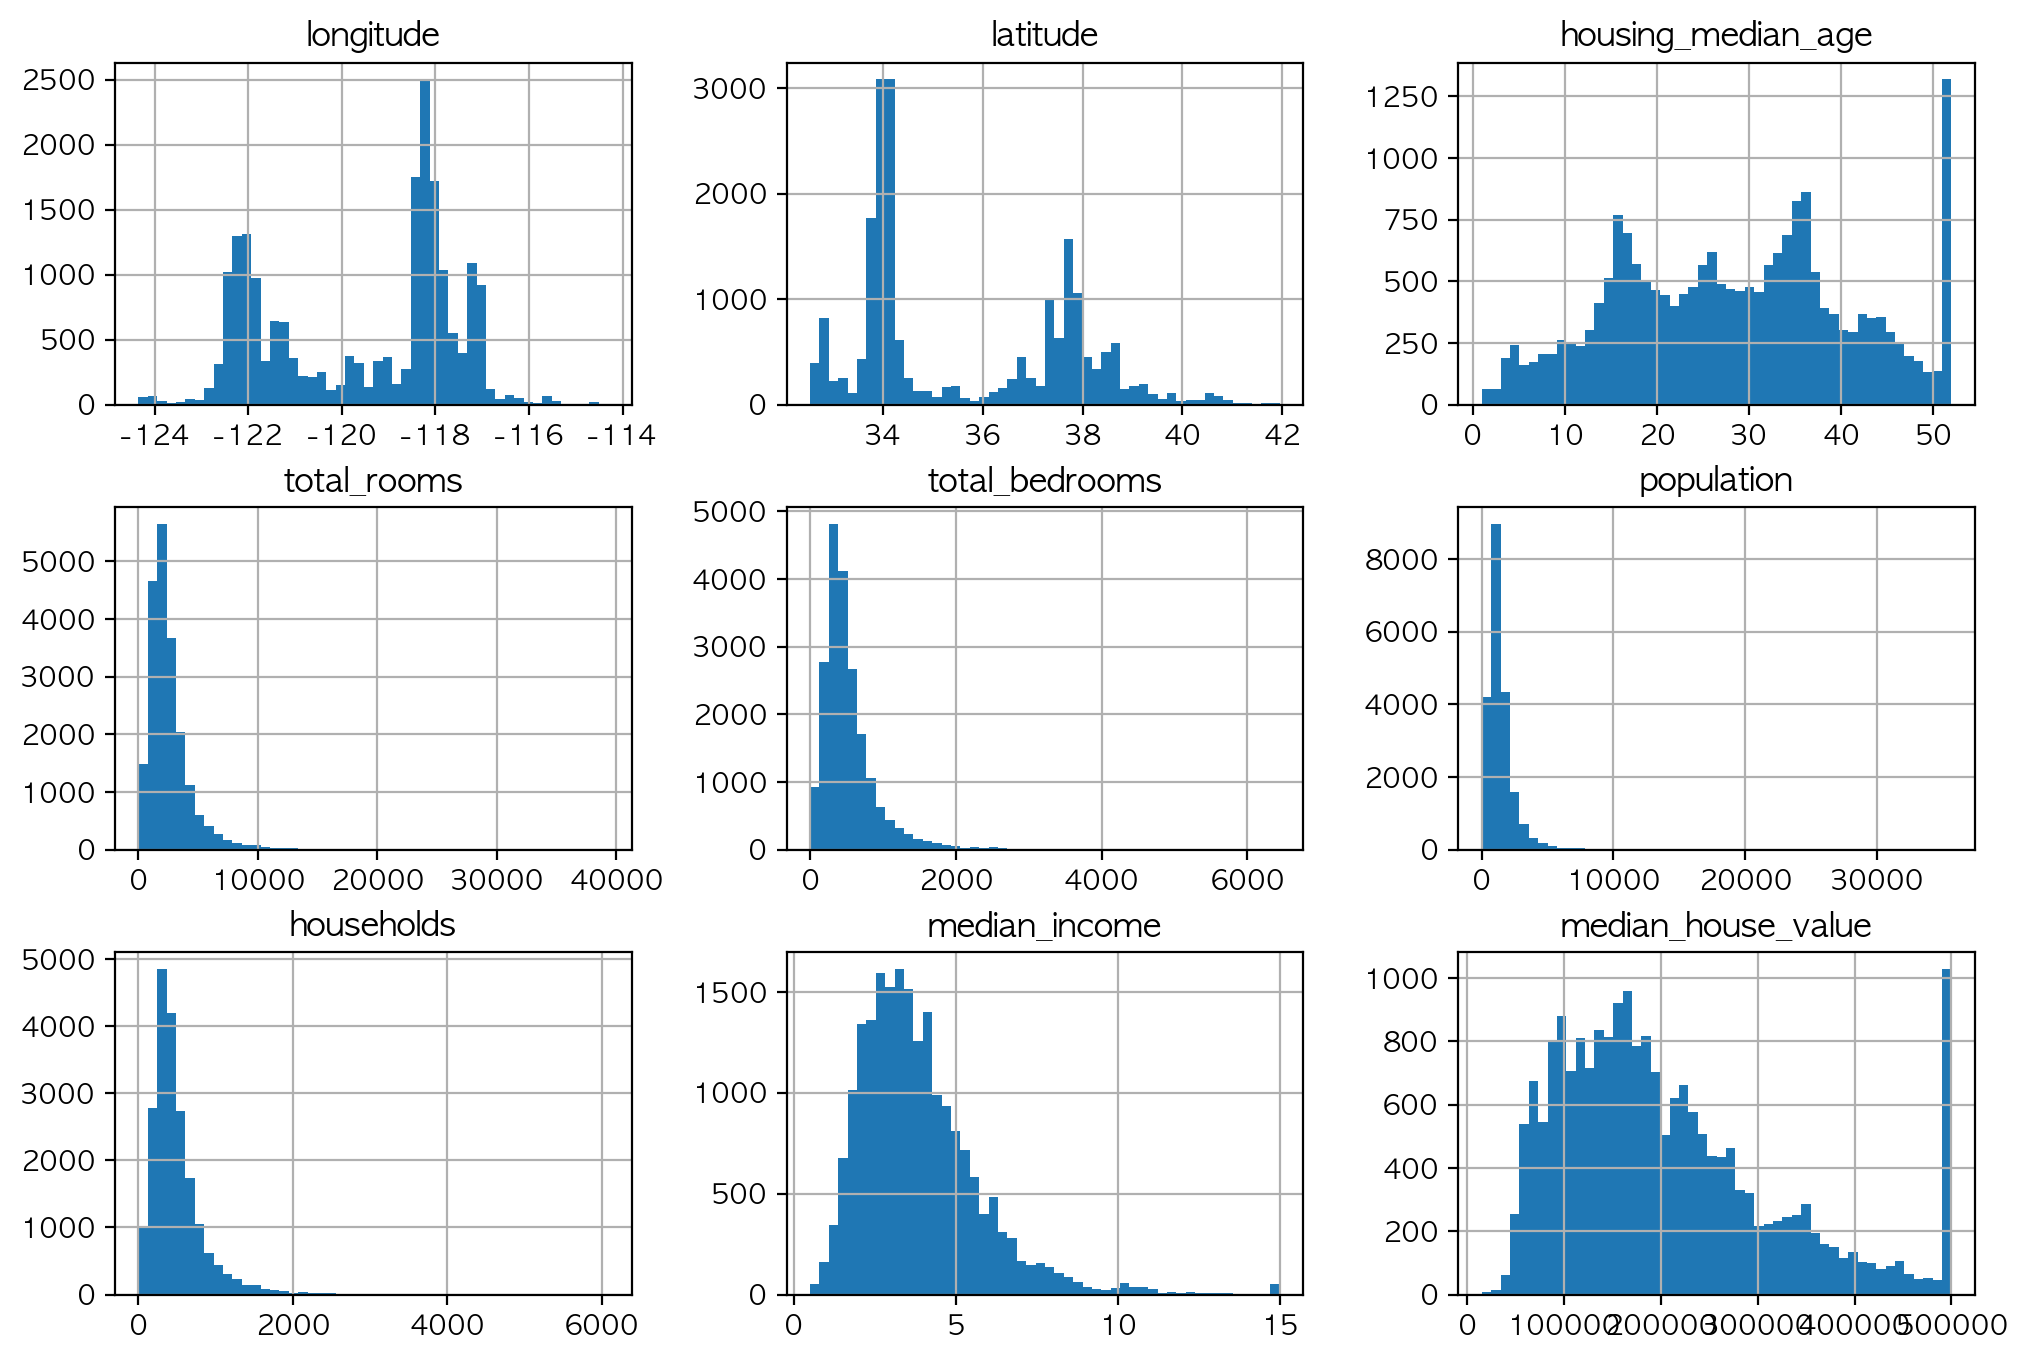

In [7]:
housing.hist(bins=50, figsize=(12,8))
plt.show()

In [8]:
import numpy as np

def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

# 데이터 셔플 시키고 비율에 따른 인덱싱 구한 뒤, 테스트와 트레인을 그 기점으로 분리
# 난수 발생의 기본 키 값이 없기 때문에 매번 다름
# np.random.seed(42)로 np.random.permutation을 호출하기 전에 사용하여 키 값 고정

In [9]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)

print(len(train_set))
print(len(test_set))

16512
4128


In [10]:
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

# 특정 열을 이용하여 데이터를 분리
# crc32로 identifier를 해쉬값으로 변환하여 test_ratio에 속하는지 판별(test_ratio*2**32에 속하는지
# 인덱스를 고유 식별자로 사용하여 새로운 데이터가 들어와도 동일한 세트에 소속되도록 할 수 있음

In [11]:
housing_with_id = housing.reset_index()
# index 열이 추가된 데이터프레임이 반환

train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

In [12]:
# indexing을 할 때에는 안전한 특성을 사용하여 고유 식별자를 만들어야한다.
# 위도와 경도를 이용하기
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]

train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")

In [13]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

데이터셋이 큰 경우 문제가 없지만 아닐 경우에 샘플링 편향이 발생 가능
미국인구 남성 51.1%, 여성 48.9% -> 추출한 데이터 셋도 511, 489명으로 구성 -> 계층적 샘플링
전체 인구는 계층이라는 동질의 그룹으로 나뉘고, 테스트 세트가 전체 인구를 대표하도록 각 계층에서 올바른 수의 샘플을 추출해야함

In [14]:
housing["income_cat"] = pd.cut(housing["median_income"],
                              bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                              labels=[1,2,3,4,5])
# 중간 소득이 0~60000$ 데이터에는 0~6이상으로 나누어져있다.
# 카테고리형 데이터로 변환

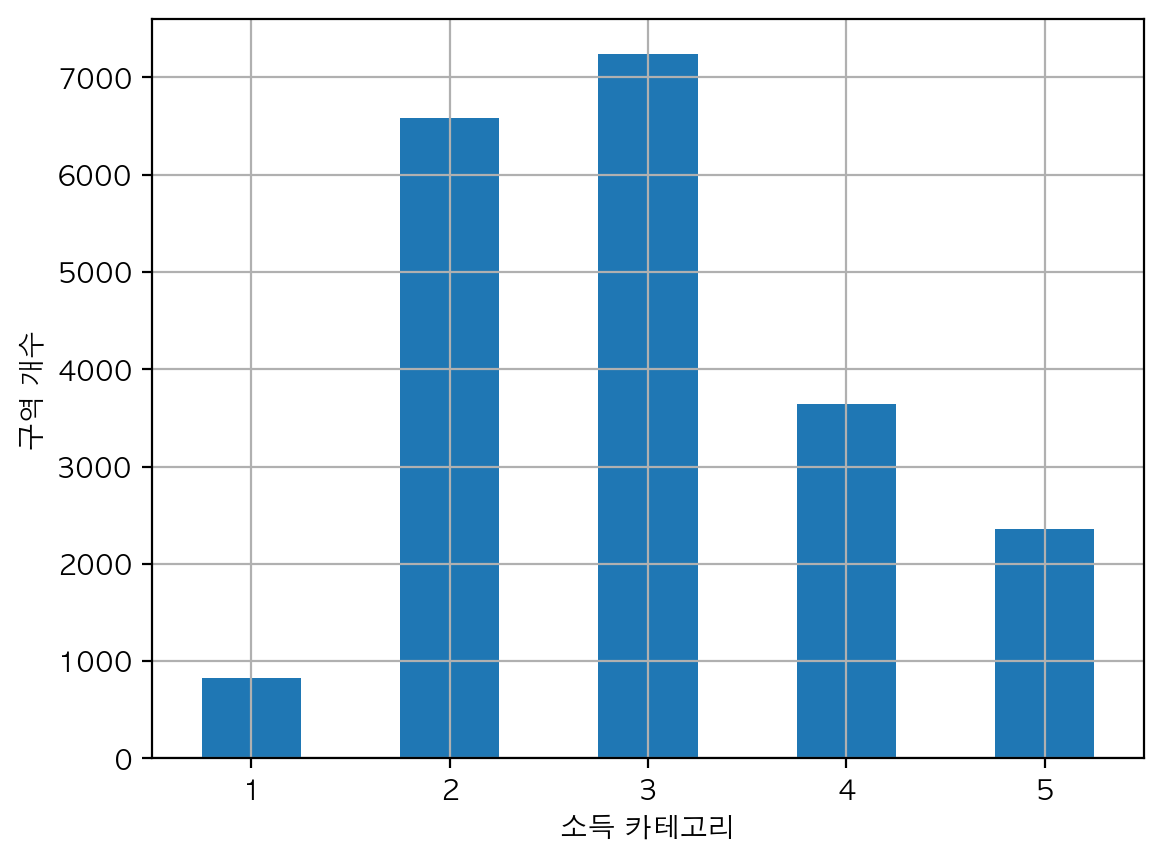

In [15]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("소득 카테고리")
plt.ylabel("구역 개수")
plt.show()

In [16]:
# 한 데이터셋으로 각각 다른 10개의 계층 분할을 생성
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []

for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

In [17]:
strat_train_set, strat_test_set = strat_splits[0]

In [18]:
strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

In [19]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set) * 100

income_cat
3    35.053295
2    31.879845
4    17.635659
5    11.434109
1     3.997093
Name: count, dtype: float64

In [20]:
# 추가 코드 – 그림 2–10를 생성합니다.

def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall %": income_cat_proportions(housing),
    "Stratified %": income_cat_proportions(strat_test_set),
    "Random %": income_cat_proportions(test_set),
}).sort_index()
compare_props.index.name = "Income Category"
compare_props["Strat. Error %"] = (compare_props["Stratified %"] /
                                   compare_props["Overall %"] - 1)
compare_props["Rand. Error %"] = (compare_props["Random %"] /
                                  compare_props["Overall %"] - 1)
(compare_props * 100).round(2)

,Overall %,Stratified %,Random %,Strat. Error %,Rand. Error %
Income Category,,,,,
1,3.98,4.00,4.24,0.36,6.45
2,31.88,31.88,30.74,-0.02,-3.59
3,35.06,35.05,34.52,-0.01,-1.53
4,17.63,17.64,18.41,0.03,4.42
5,11.44,11.43,12.09,-0.08,5.63


In [21]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [22]:
housing = strat_train_set.copy()

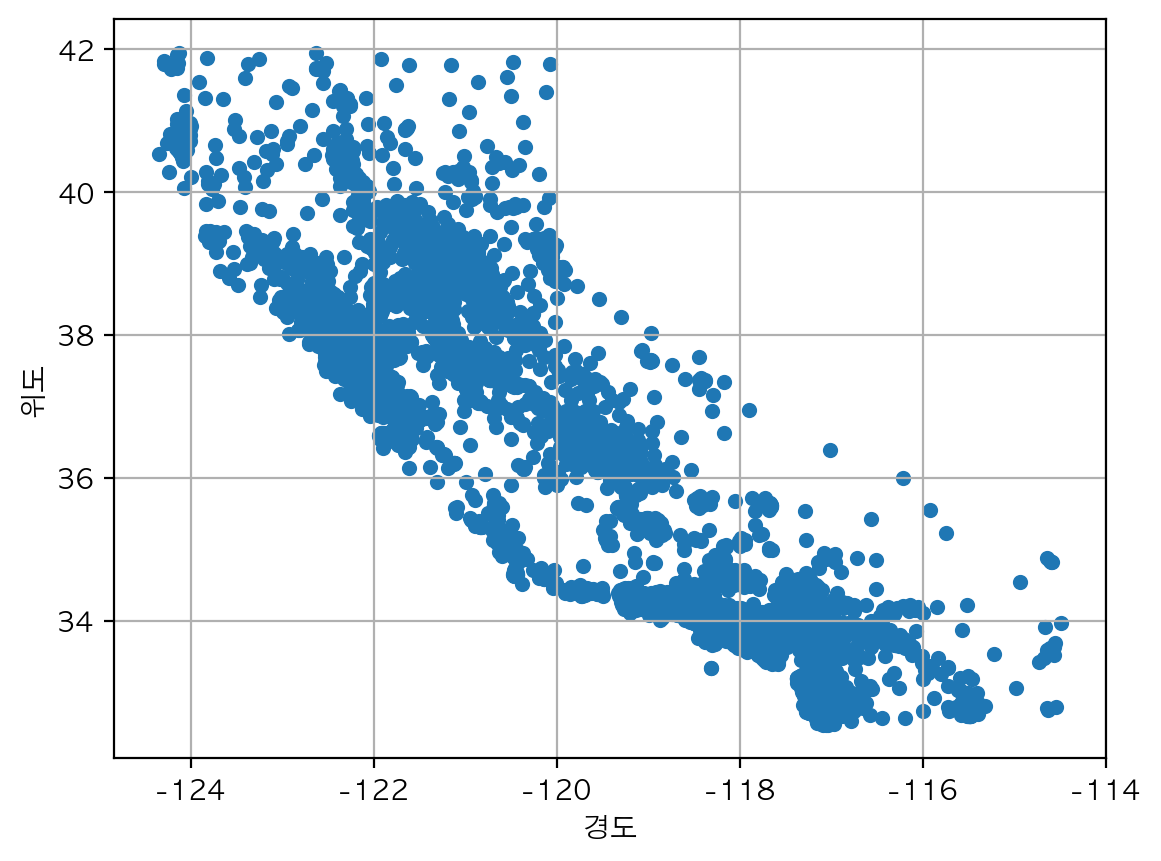

In [23]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True)
plt.xlabel("경도")
plt.ylabel("위도")
plt.show()

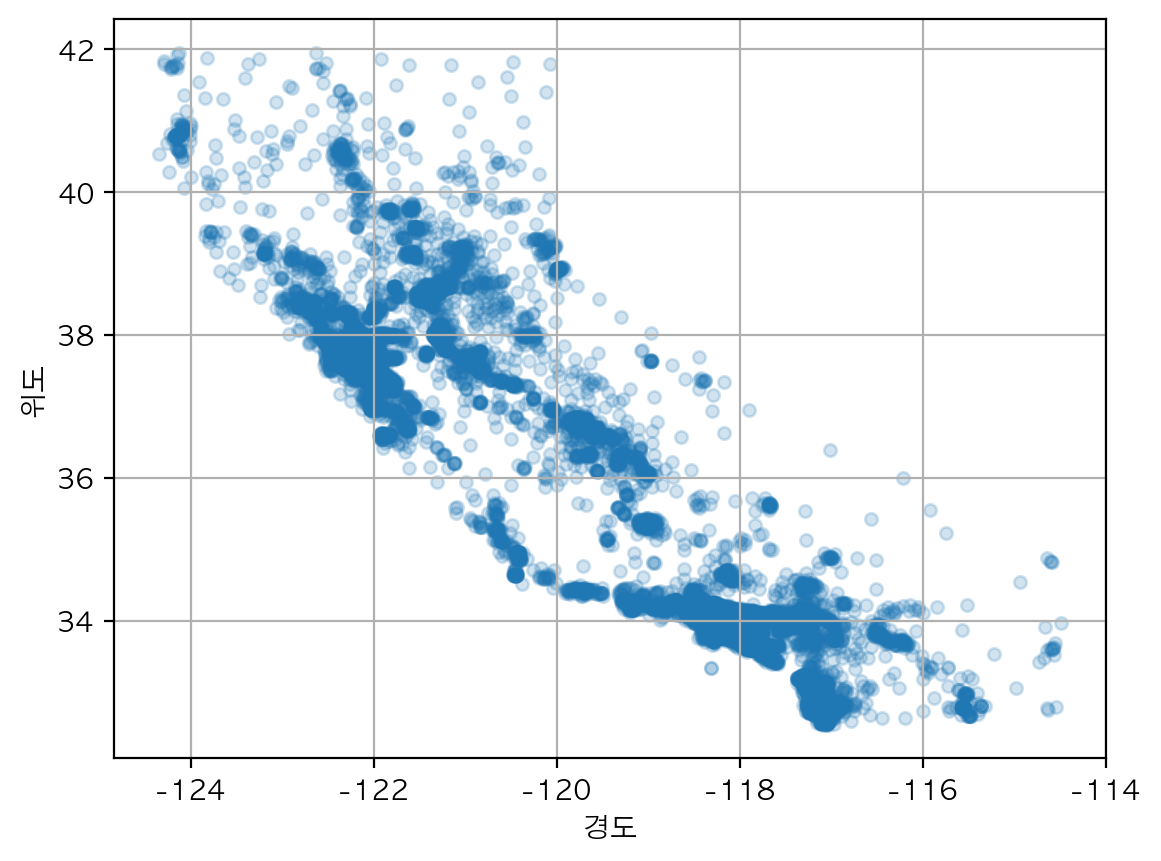

In [24]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
plt.xlabel("경도")
plt.ylabel("위도")
plt.show()

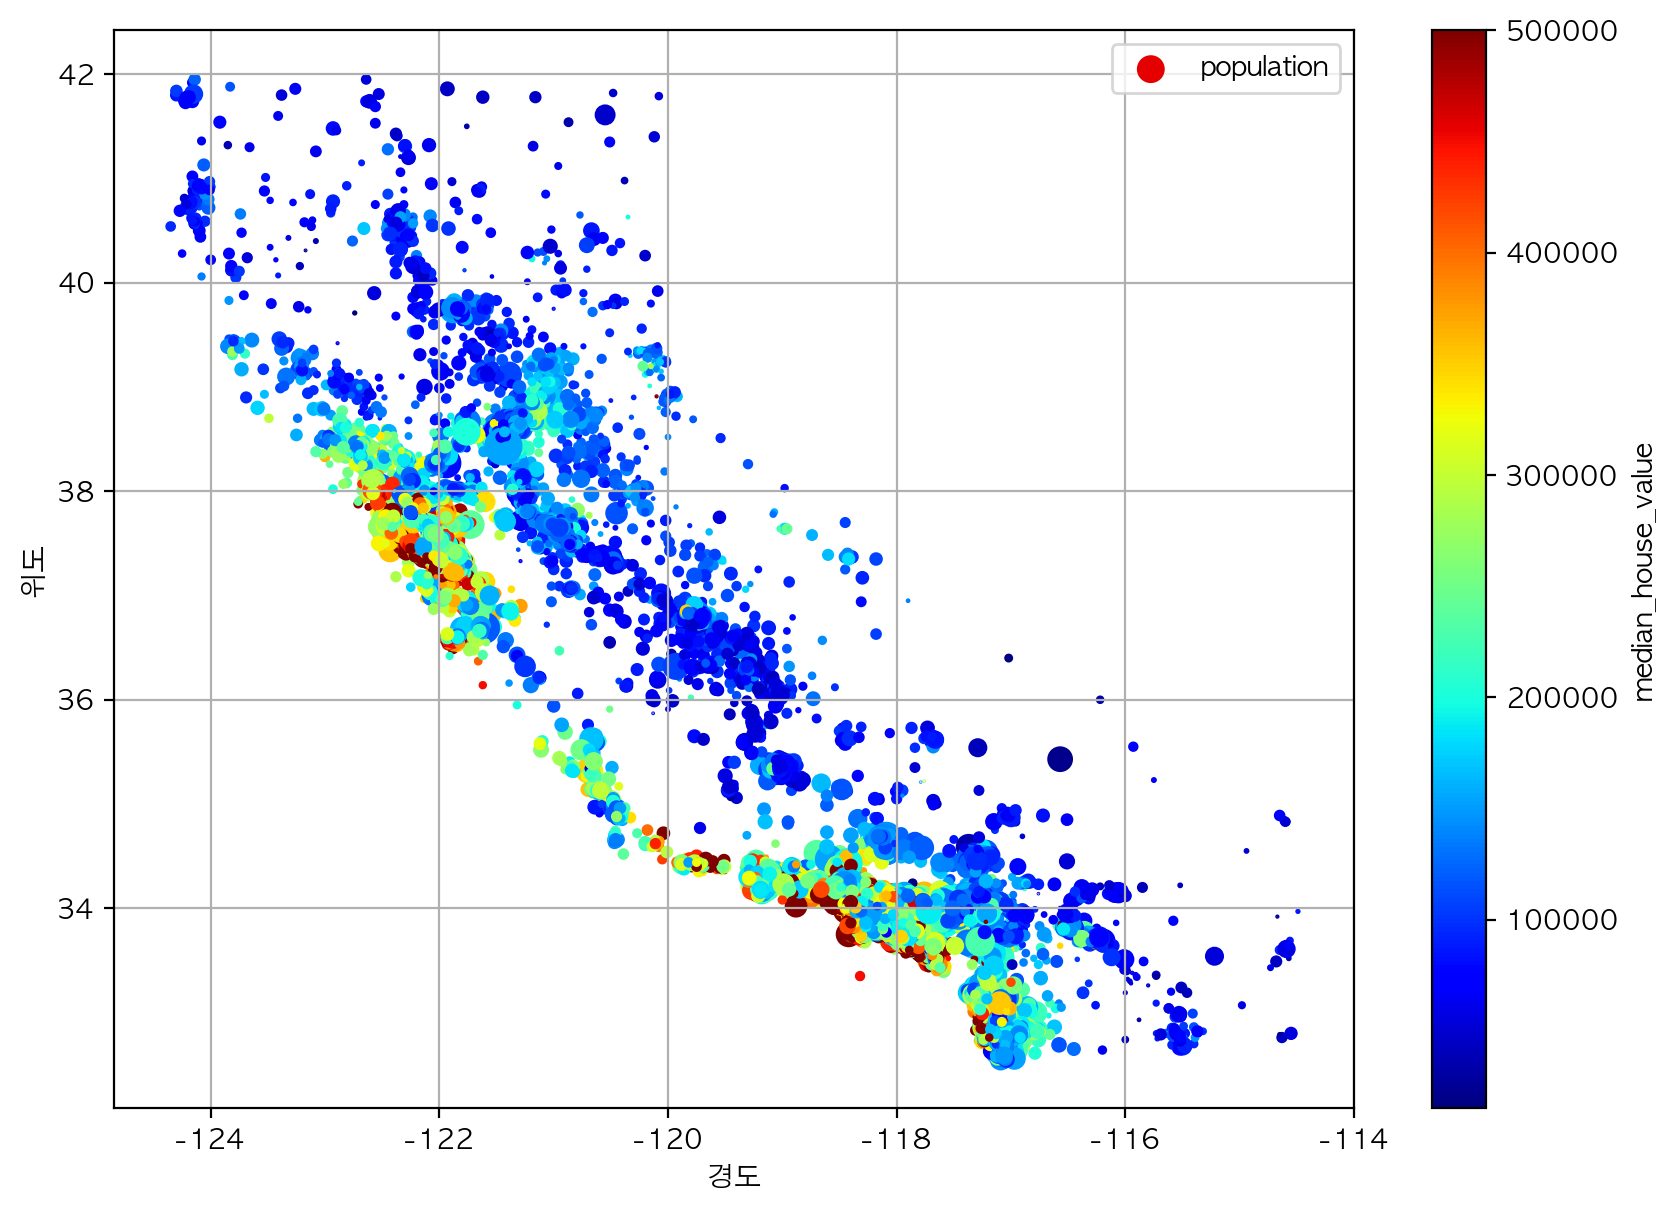

In [25]:
housing.plot(kind='scatter', x='longitude', y='latitude', grid=True,
            s=housing["population"] / 100, label='population',
            c='median_house_value', cmap='jet', colorbar=True,
            figsize=(10, 7))

plt.xlabel('경도')
plt.ylabel('위도')
plt.legend()
plt.show()

In [26]:
corr_matrix = housing.corr(numeric_only=True)
# 표준 상관계수

corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

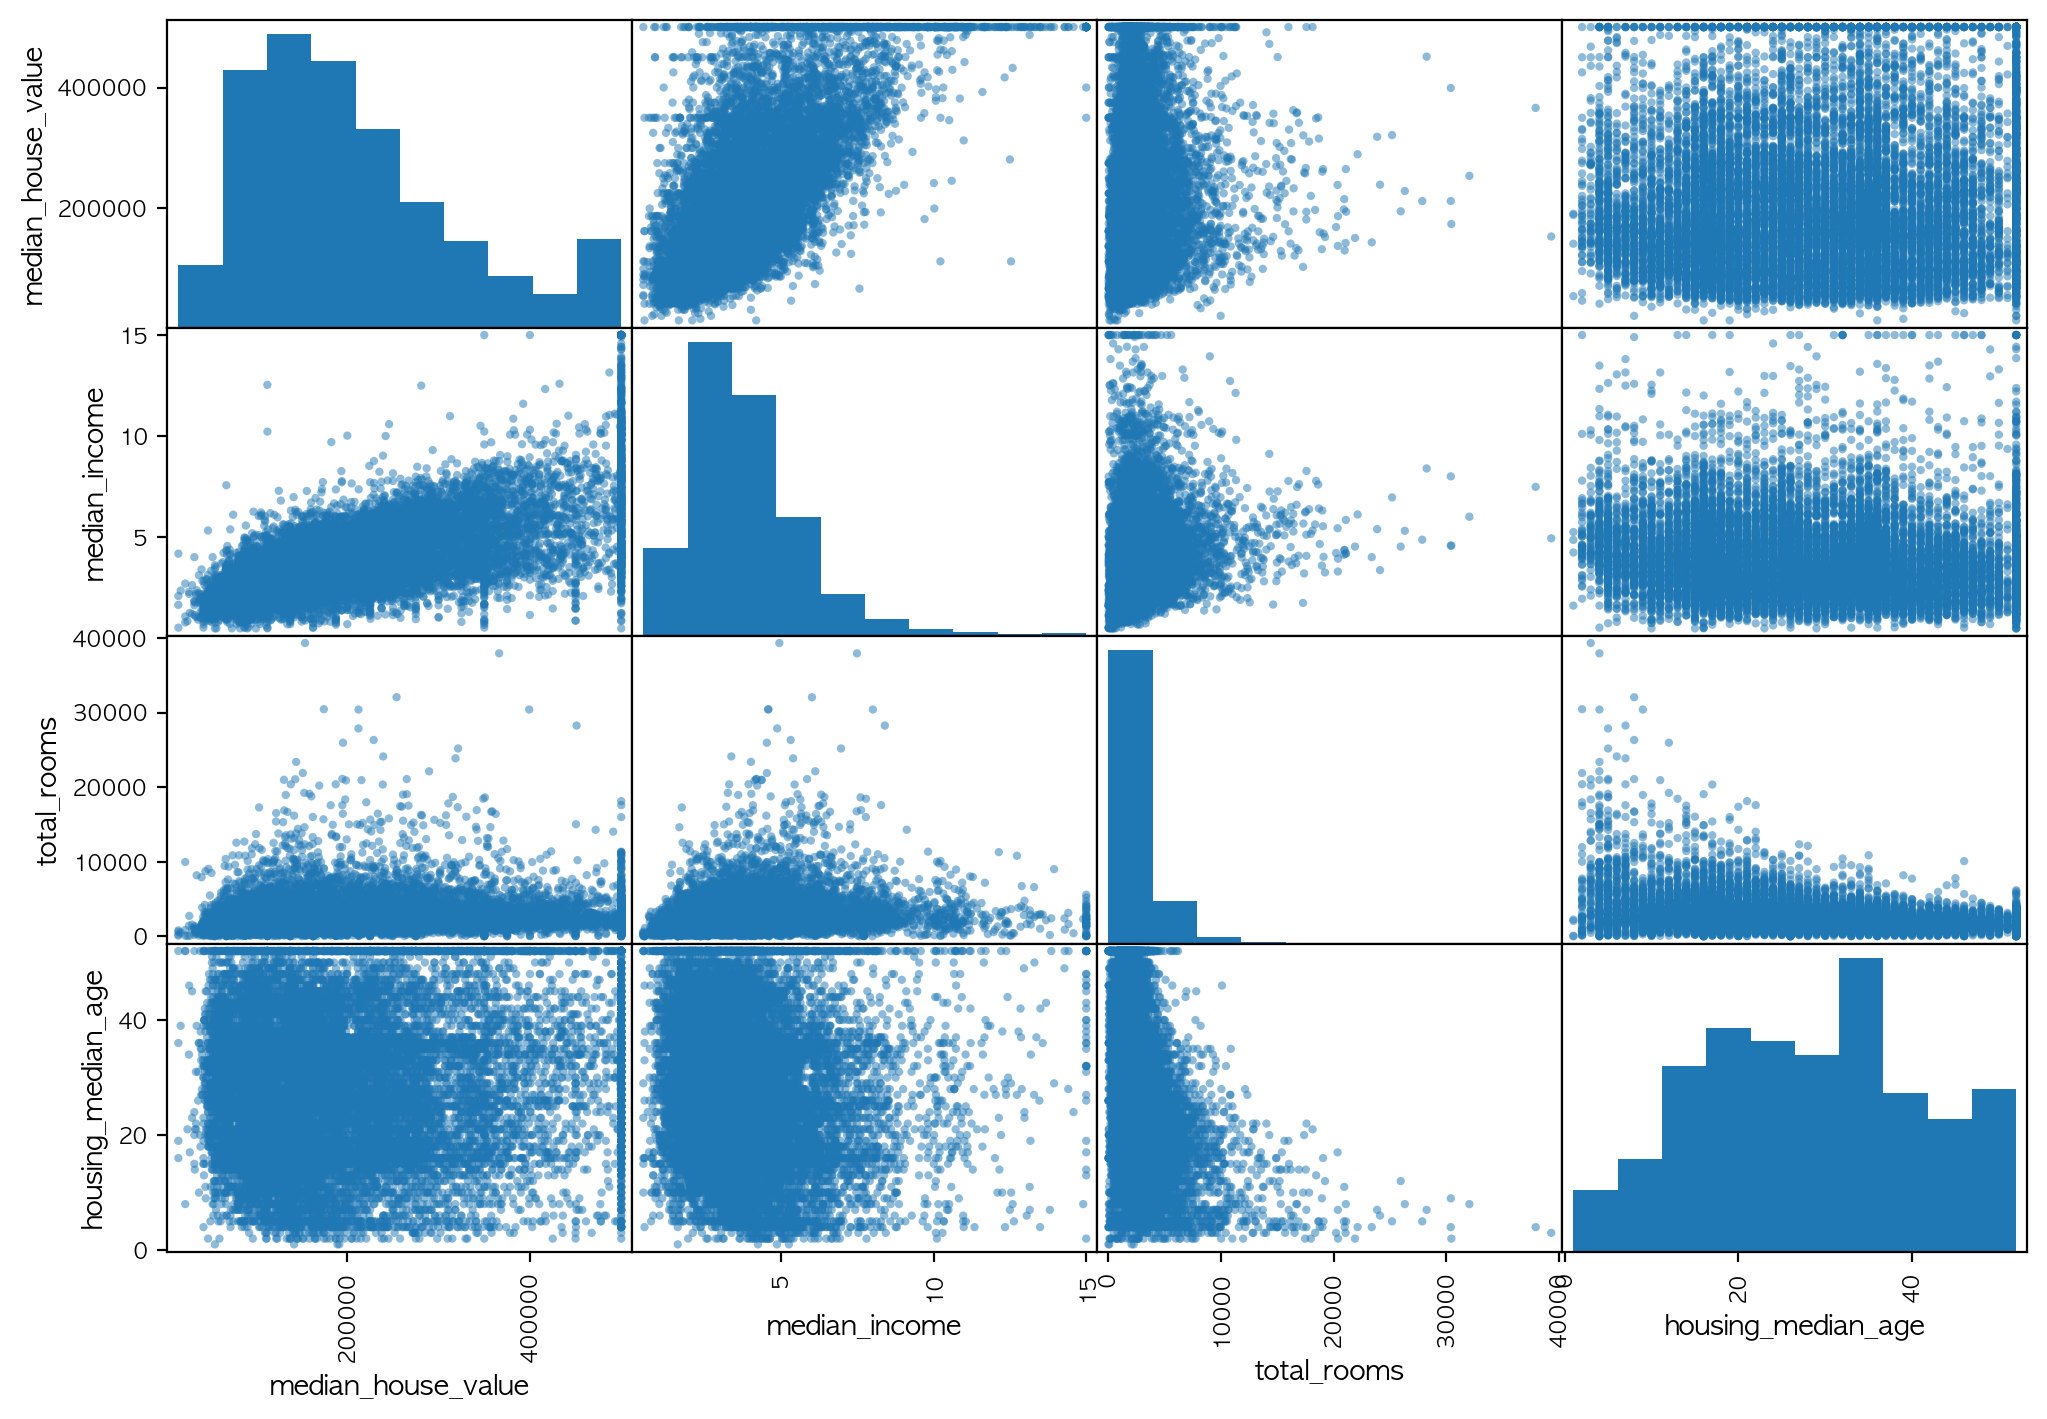

In [27]:
from pandas.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes], figsize=(12,8))
plt.show()

Text(0, 0.5, '중간 주택 가격')

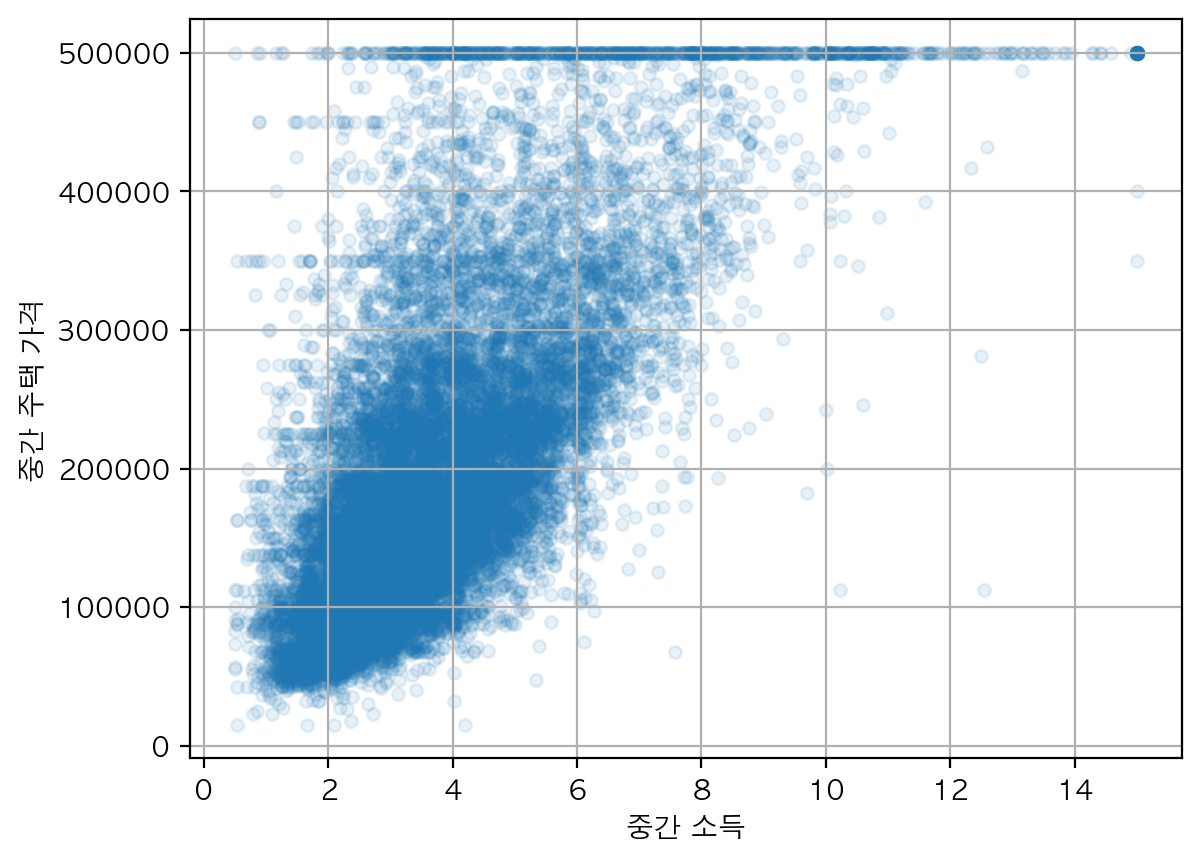

In [28]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1, grid=True)
plt.xlabel('중간 소득')
plt.ylabel('중간 주택 가격')

In [29]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_house"] = housing["population"] / housing["households"]

In [30]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value      1.000000
median_income           0.688380
rooms_per_house         0.143663
total_rooms             0.137455
housing_median_age      0.102175
households              0.071426
total_bedrooms          0.054635
population             -0.020153
population_per_house   -0.038224
longitude              -0.050859
latitude               -0.139584
bedrooms_ratio         -0.256397
Name: median_house_value, dtype: float64

In [31]:
housing = strat_train_set.drop("median_house_value", axis=1) # input
housing_labels = strat_train_set["median_house_value"].copy() # target

In [32]:
# housing.dropna(subset=['total_bedrooms'], inplace=True)
# housing.drop('total_bedrooms', axis=1, inplace=True)
median = housing['total_bedrooms'].median()
housing['total_bedrooms'].fillna(median, inplace=True)

In [33]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

In [34]:
housing_num = housing.select_dtypes(include=[np.number])
# print(housing_num)

In [35]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [36]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [37]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [38]:
X = imputer.transform(housing_num)

In [39]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

In [40]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(8)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY


In [41]:
# 범주형 데이터 숫자로 변환
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

housing_cat_encoded[:8]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.]])

In [42]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [43]:
# 위의 방식은 가까이 있는 둘이 멀리 있는 두 개의 범주보다 관련성 있다고 생각한다.
# 그것을 사용하는 것도 있지만 여기서는 아니다.
# 장소마다 연관성이 없기 때문에 한 범주에 해당했을 때 그 범주 외에 0으로 판단하는 원핫인코딩을 실행
# 대부분이 0이기 때문에 희소행렬로 나온다.
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

housing_cat_1hot
# OneHotEncoder 생성 시 sparse=False(or spars_output=False)로 설정하여 transform()메서드가 일반적인 넘파이 배열을 반환하게 가능

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [44]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [45]:
cat_encoder = OneHotEncoder(sparse_output=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [46]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [47]:
df_test = pd.DataFrame({"ocean_proximity": ["INLAND", "NEAR BAY"]})
pd.get_dummies(df_test)

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,True,False
1,False,True


In [49]:
cat_encoder.transform(df_test)
cat_encoder.transform(df_test)

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [50]:
df_test_unknown = pd.DataFrame({"ocean_proximity": ["<2H OCEAN", "ISLAND"]})
# print(pd.get_dummies(df_test_unknown))
# print(df_test_unknown)
pd.get_dummies(df_test_unknown)

,ocean_proximity_<2H OCEAN,ocean_proximity_ISLAND
0,True,False
1,False,True


In [52]:
cat_encoder.handle_unknown = "ignore"
cat_encoder.transform(df_test_unknown)

array([[0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [53]:
cat_encoder.feature_names_in_
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [55]:
df_output = pd.DataFrame(cat_encoder.transform(df_test_unknown),
                         columns=cat_encoder.get_feature_names_out(),
                         index=df_test_unknown.index)

In [57]:
df_output

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0
